# Modeling emission inequality

This notebook introduces a simple model of the connection between inequality and well-being under a limited emission budget.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Global income shares

As input data, we use the income shares of each percentile of the global population of 2016, taken from the [World Inequality Database](https://wid.world/).

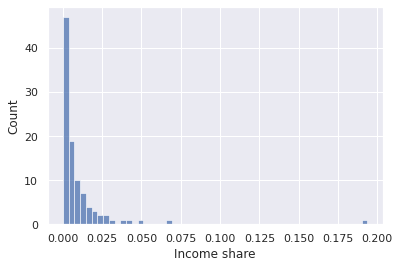

In [19]:
income_shares = list(pd.read_csv(f'data/income_shares_2016.csv')['value'])
ax = sns.histplot(income_shares)
ax.set_xlabel('Income share');

We define a function that can redistribute income between each percentile.

In [26]:
def redist(x, p):
    """ Redistribute values x by a percentage p in [0, 1]. """
    x = np.array(x)
    y = np.sum(x * p) / len(x)
    return x - x * p + y

For example, the following represents a redistribution by 50%.

In [29]:
redist_income_shares = redist(income_shares, 0.5)

We can measure and compare the inequality of different distributions with the Gini coefficient, as defined [here](https://stackoverflow.com/a/39513799).

In [30]:
def gini(x):
    """ Takes a list of values and returns the Gini coefficient. """
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad    

print(f"Gini coefficient before redistribution: {gini(income_shares)}")
print(f"Gini coefficient after redistribution: {gini(redist_income_shares)}")

Gini coefficient before redistribution: 0.6645114511451145
Gini coefficient after redistribution: 0.3322557255725572


## The model

We can now define our model. We make the following assumptions:

- The model consists of 100 people, each representing 1% of the global population.
- Peoples income share reflect global data from 2016, subject to a certain level of `redistribution`.
- There is a fixed global emission budget (reflecting a maximum amount of emissions per year).
- Income shares are equal to `emission_shares`, i.e. the share of the global emission budget that each person is able to access.
- There is a `min_share` - a minimum emission share that is needed to live a good life. Both technological improvements and cultural changes could affect this value.

The following function can calculate the share of people living a good life, given parameters of `min_share` and `redistribution`.

In [34]:
def calc_good_life_share(min_share, redistribution):

    emission_shares = pd.read_csv(f'data/income_shares_2016.csv')['value']
    redist_emission_shares = redist(emission_shares, redistribution)
    n_good_life = sum([res >= min_share for res in redist_emission_shares]) 
    
    return n_good_life / 100

We now define an experiment with this model, using different parameter values.

In [50]:
def run_experiment(min_share_range, redistribution_range):

    results = []
    for min_share in np.linspace(*min_share_range, 10):
        for redistribution in np.linspace(*redistribution_range, 10):
            good_life_share = calc_good_life_share(
                min_share = min_share,
                redistribution = redistribution
            )
            results.append([good_life_share, min_share, redistribution])

    columns = ['good_life_share', 'min_share', 'redistribution']
    return pd.DataFrame(results, columns=columns)

Finally, we define a function to visualize the results of this experiment, using the seaborn and matplotlib libraries.

In [57]:
def plot_simulation(results, min_share_range):
    
    # Main plot
    ax = sns.lineplot(
        data=results, 
        x='redistribution', 
        y='good_life_share', 
        hue='min_share',
        palette='cool',
    )
    
    # Colorbar
    sm = plt.cm.ScalarMappable(
        cmap='cool', 
        norm=plt.Normalize(*min_share_range))
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm)
    cbar.ax.get_yaxis().labelpad = 20
    cbar.set_label('min_share', rotation=270)

## Results and discussion

We can now run and visualize the experiment for different parameter ranges as follows:

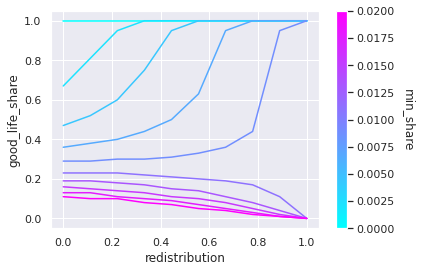

In [58]:
min_share_range = (0, 2/100)
redistribution_range = (0, 1)
results = run_experiment(min_share_range, redistribution_range)
plot_simulation(results, min_share_range)

**Questions for discussion**:

- Why does more redistribution lead to a higher share of people living a good life for min_share > 0.01?
- Why does the share of people living a good life drop to zero for redistribution = 1 and min_share > 0.01?
- What value of min_share would we expect there to be in the real world?
- What kind of knowledge can we gain (or not gain) from this model?